## Preambule

In [1]:
import numpy as np
import xarray as xr
from importlib import reload
import pandas as pd
from tqdm import tqdm
import json
from pathlib import Path
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [44]:
import Functions
reload(Functions)
from Functions import (pop_func, emis_func, determine_coefficient,
                       popshare_func, emisshare_func, emis_total_func, rho, cumpopshare_func,
                       cumfuturepop_func, emis_f_func, gdp_future, create_groups)

## Run class or read xarray file

In [93]:
import ClassEffortSharing
reload(ClassEffortSharing)
from ClassEffortSharing import shareefforts

efshare = shareefforts()
efshare.define_paths()
efshare.read_countrygroups()
if efshare.reread == True:
    efshare.read_unpop()
    efshare.read_hdi()
    efshare.read_gdp()
    efshare.read_edgar()
    efshare.read_primap()
    efshare.read_ar6()
    efshare.read_ndc_cr()
    efshare.read_ndc()
    efshare.read_baseline()
    efshare.concat_xrobject()
    efshare.save_xrs_databases()
else:
    efshare.load_xrs_databases()
efshare.general_calculations()          # 28s
efshare.calc_budgets_static()           # 1m 15s
efshare.calc_budgets_dynamic()          # 1m
efshare.save_budgets()
self = efshare

# ==================================== #
# Initializing shareefforts class    #
# ==================================== #
- Defining paths
- Reading country groups
- Load XR databases
- General calculations for effort sharing
  o Determine CCS
  o Determine global variables
  o Calculate historical cumulative variables
  o Calculate Pop fractions for PC
  o Calculate Fyson 1 neg budgets (dynamic gdp)
  o Calculate Fyson 2 positive shares
  o Calculate Fyson 2 negative shares
- Calculating static budgets
- Calculating temporal evolution by straight line


100%|██████████| 12/12 [02:20<00:00, 11.71s/it]


- Some general share information
- Calculating temporal evolution following cost-optimal scenario information


12it [00:38,  3.19s/it]


- Save budgets


In [86]:
var = 'A2_gdp_net'
reg = 'USA'
for c_i, c in enumerate(['C1+C2', 'C3']):
    print(c, float(self.xr_budgets_static.sel(Ccat=c, Region=reg, Variable=var).Value))

C1+C2 -53.24753263672047
C3 -35.8986331555672


In [89]:
self.app2_nets.shape

(12, 262, 82)

In [4]:
# for r_i, r in enumerate(self.countries_iso):
#     b = float(self.xr_budgets_static.sel(Ccat="C1", Variable="A2_gdp_net", Region=r).Value)
#     pop = float(self.xr_total.Population.sel(Time=2020, ISO=r))
#     if b/pop>8e-7:
#         print(r, b/pop, b)

In [5]:

future_gdp_w = np.array([gdp_future(self, y, "WORLD", 'abs') for y in np.arange(2020, 2101)])
future_pop_w = np.array([pop_func(self, y, "WORLD") for y in np.arange(2020, 2101)])
future_bau_w = np.array(self.xr_total.GHG_base.sel(ISO='WORLD', Time=np.arange(2020, 2101)))

RA = np.zeros(shape=(len(self.all_regions_iso), len(np.arange(2020, 2101)), len(self.all_categories)))
for cat_i, cat in enumerate(self.all_categories):
    future_emis_w = np.array(self.xr_total.GHG_f.sel(Category=cat, Time = np.arange(2020, 2101)))
    for cty_i, cty in enumerate(self.all_regions_iso):
        future_bau = np.array(self.xr_total.GHG_base.sel(ISO=cty, Time=np.arange(2020, 2101)))
        future_gdp = np.array(self.xr_total.GDP.sel(ISO=cty, Time=np.arange(2020, 2101)))
        future_pop = np.array(self.xr_total.Population.sel(ISO=cty, Time=np.arange(2020, 2101)))
        RA[cty_i, :, cat_i] = ((future_gdp/future_pop) / (future_gdp_w/future_pop_w) )**(1/3.)*future_bau*(future_bau_w - future_emis_w)/future_bau_w

self.ap_RA = RA
self.ap_corr = (np.nansum(RA, axis=0).T/(future_bau_w - future_emis_w)).T


In [6]:
self.ap_RA

array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             

In [7]:
#plt.plot(np.arange(2020, 2100), self.xr_total.GHG_f_co2.sel(Category='C2', Time=np.arange(2020, 2100)), label='AR6, CO$_2$, incl LULUCF')

fig = plt.figure(figsize=(10, 5))
Y = np.array(DF_raw[DF_raw.Variable == "Emissions|Kyoto Gases"][DF_raw.keys()[5:-1]])
ms = np.array(DF_raw[DF_raw.Variable == "Emissions|Kyoto Gases"].ModelScenario)
for dat in range(len(Y)):
    y = Y[dat]/1000
    t = np.array(DF_raw.keys()[5:-1]).astype(int)
    #plt.plot(t, y, ',', c='k', lw=0.5)
    try:
        if modcat[:, np.where(modcat[0] == ms[dat])][1][0][0] == "C2":
            plt.plot(t, y, '.', c='tomato', lw=0.5)
    except:
        continue

plt.plot(np.arange(2020, 2100), self.xr_total.GHG_f_incl.sel(Category='C2', Time=np.arange(2020, 2100)), c='tomato', lw=3, label="AR6 (C2), GHG, incl LULUCF")
plt.plot(np.arange(2020, 2100), self.xr_total.GHG_f.sel(Category='C2', Time=np.arange(2020, 2100)), label="AR6 (C2), GHG, no LULUCF")
plt.ylabel("Emissions (Gt CO2e)")

# Historical
plt.plot(self.xr_total.Time, self.xr_total.GHG_p.sel(ISO='WORLD'), label="Historical, no LULUCF")
plt.plot(self.xr_total.Time, self.xr_total.GHG_p_incl.sel(ISO='WORLD'), label="Historical, incl LULUCF")
plt.xlim([2000, 2100])
plt.plot([-1e3, 2e5], [0, 0], 'k', lw=0.5)
plt.legend()

NameError: name 'DF_raw' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
self.xr_total.GHG_f_incl.sel(Category='C2', Time=np.arange(2020, 2101)).sum()

<xarray.DataArray 'GHG_f_incl' ()>
array(1120.81562955)
Coordinates:
    Category  <U2 'C2'

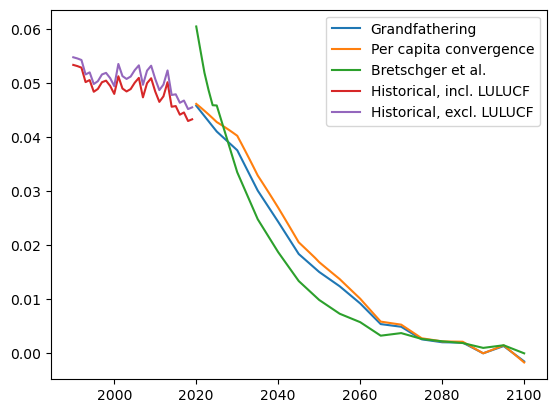

In [ ]:
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_scenario.sel(Ccat="C2", Region='CHE', Variable="GF").Value, label="Grandfathering")
#plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_scenario.sel(Ccat="C2", Region="CHE", Variable="GF").Value))
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_scenario.sel(Ccat="C2", Region='CHE', Variable="PCC").Value, label="Per capita convergence")
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_scenario.sel(Ccat="C2", Region='CHE', Variable="BR").Value, label="Bretschger et al.")
plt.plot(self.xr_total.Time, self.xr_total.GHG_p_incl.sel(ISO = 'CHE'), label='Historical, incl. LULUCF')
plt.plot(self.xr_total.Time, self.xr_total.GHG_p.sel(ISO = 'CHE'), label='Historical, excl. LULUCF')
plt.legend()

In [ ]:
self.xr_budgets_linear.sel(Ccat="C2", Region='CHE', Variable="BR").Value.sum()

<xarray.DataArray 'Value' ()>
array(1.04193821)
Coordinates:
    Ccat      <U2 'C2'
    Region    <U3 'CHE'
    Variable  <U2 'BR'

In [ ]:
self.xr_budgets_scenario.sel(Ccat="C2", Region='CHE', Variable="BR").Value.sum()/self.xr_budgets_scenario.sel(Ccat="C2", Region='WORLD', Variable="BR").Value.sum()

<xarray.DataArray 'Value' ()>
array(0.00105395)
Coordinates:
    Ccat      <U2 'C2'
    Variable  <U2 'BR'

In [ ]:
self.xr_budgets_static.sel(Ccat="C2", Region='CHE', Variable=["BR", "PC"])

<xarray.DataArray 'Value' (Variable: 2)>
array([1.04193821, 1.35407752])
Coordinates:
    Region    <U3 'CHE'
    Ccat      <U2 'C2'
  * Variable  (Variable) object 'BR' 'PC'

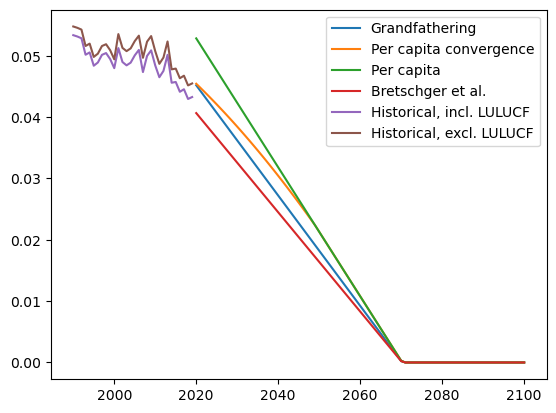

In [ ]:
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_linear.sel(Ccat="C2", Region='CHE', Variable="GF").Value, label="Grandfathering")
#plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_scenario.sel(Ccat="C2", Region="CHE", Variable="GF").Value))
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_linear.sel(Ccat="C2", Region='CHE', Variable="PCC").Value, label="Per capita convergence")
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_linear.sel(Ccat="C2", Region='CHE', Variable="PC").Value, label="Per capita")
plt.plot(self.xr_budgets_scenario.Time, self.xr_budgets_linear.sel(Ccat="C2", Region='CHE', Variable="BR").Value, label="Bretschger et al.")
plt.plot(self.xr_total.Time, self.xr_total.GHG_p_incl.sel(ISO = 'CHE'), label='Historical, incl. LULUCF')
plt.plot(self.xr_total.Time, self.xr_total.GHG_p.sel(ISO = 'CHE'), label='Historical, excl. LULUCF')
plt.legend()

Text(0, 0.5, 'Global GHG emissions')

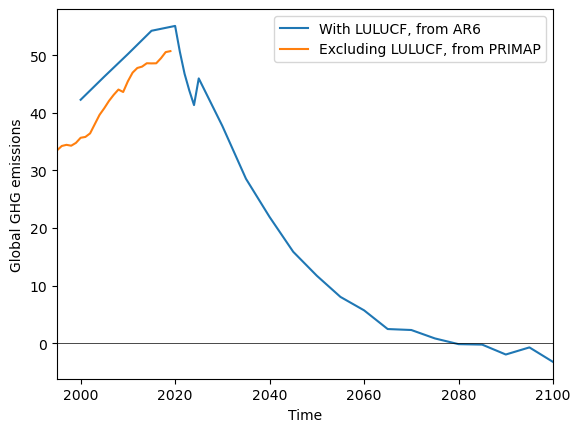

In [ ]:
#plt.plot(self.xr_total.Time, self.xr_total.GHG_f.sel(Category='C1+C2'), label='Without LULUCF')
# y = np.array(DF_new[(DF_new.Variable == "Emissions|Kyoto Gases") & (DF_new.Category == 'C1+C2')].Mean)/1000
# plt.plot(np.unique(DF_new.Time)[~np.isnan(y)], y[~np.isnan(y)], label='With LULUCF, from AR6')
plt.plot(self.xr_total.Time, self.xr_total.GHG_f_incl.sel(Category="C1+C2"), label='With LULUCF, from AR6')
plt.plot(self.xr_total.Time, self.xr_total.GHG_p.sel(ISO='WORLD'), label='Excluding LULUCF, from PRIMAP')
plt.xlim([1995, 2100])
plt.plot([-1, 1e4], [0, 0], 'k', lw=0.5)
plt.xlabel('Time')
plt.legend()
plt.ylabel('Global GHG emissions')

In [ ]:
y

array([        nan,         nan,         nan,         nan,         nan,
       42.26548087,         nan,         nan,         nan,         nan,
       46.27952287,         nan,         nan,         nan,         nan,
       50.19646491,         nan,         nan,         nan,         nan,
       54.23974233,         nan,         nan,         nan,         nan,
       55.08147336, 50.60468078, 46.77787818, 43.88276017, 41.34085522,
       45.97121302,         nan,         nan,         nan,         nan,
       37.71475422,         nan,         nan,         nan,         nan,
       28.55338536,         nan,         nan,         nan,         nan,
       21.92002911,         nan,         nan,         nan,         nan,
       15.88380103,         nan,         nan,         nan,         nan,
       11.7246772 ,         nan,         nan,         nan,         nan,
        8.05191307,         nan,         nan,         nan,         nan,
        5.72210392,         nan,         nan,         nan,      

In [ ]:
DF_raw_iso3 = pd.read_csv(self.path_ar6_data_iso3)
DF_raw_iso3_onlyco2 = DF_raw_iso3[DF_raw_iso3.Variable == "Emissions|CO2"]
DF_raw_iso3_onlyco2 = DF_raw_iso3_onlyco2.reset_index(drop=True)

In [ ]:
DF_raw_raw = pd.read_csv(self.path_ar6_data_w)

In [ ]:
time_keys = np.array(list(np.arange(1995, 2021, 5))+list(np.arange(2025, 2051, 5))+list(np.arange(2060, 2101, 10))).astype(str)

DF_raw_iso3 = pd.read_csv(self.path_ar6_data_iso3)
DF_raw_iso3 = DF_raw_iso3[DF_raw_iso3.Variable.isin(self.ar6_vars_to_keep)]
DF_raw_iso3 = DF_raw_iso3.reset_index(drop=True)
DF_meta_iso3 = pd.read_excel(self.path_ar6_meta_iso3, sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(DF_meta_iso3.Model)
scens = np.array(DF_meta_iso3.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
DF_meta_iso3['ModelScenario'] = modscens_meta
modcat = np.array([np.array(DF_meta_iso3.ModelScenario), np.array(DF_meta_iso3.Category)])
mods = np.array(DF_raw_iso3.Model)
scens = np.array(DF_raw_iso3.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
DF_raw_iso3['ModelScenario'] = modscens

df_b = DF_raw[DF_raw.ModelScenario == 'IMAGE 3.2|SSP2-baseline']
baseline_emissions = (np.array(df_b[df_b.Variable == "Emissions|Kyoto Gases"][time_keys])[0]-
                    np.array(df_b[df_b.Variable == "Emissions|CH4|AFOLU|Land"][time_keys])[0]*self.gwp_ch4 -
                    np.array(df_b[df_b.Variable == "Emissions|CO2|AFOLU|Land"][time_keys])[0] -
                    np.array(df_b[df_b.Variable == "Emissions|N2O|AFOLU|Land"][time_keys])[0]*self.gwp_n2o/1000)

In [ ]:
df_b_iso3 = DF_raw_iso3[DF_raw_iso3.ModelScenario == 'IMAGE 3.2|SSP2-baseline']
unireg = np.unique(df_b_iso3.Region)
dict_baselines = {}
for r_i, r in enumerate(unireg):
    df_b_iso3_r = df_b_iso3[df_b_iso3.Region == r]
    baseline_emissions_r = (np.array(df_b_iso3_r[df_b_iso3_r.Variable == "Emissions|Kyoto Gases"][time_keys])[0] -
                            np.array(df_b_iso3_r[df_b_iso3_r.Variable == "Emissions|CH4|AFOLU|Land"][time_keys])[0]*self.gwp_ch4 -
                            np.array(df_b_iso3_r[df_b_iso3_r.Variable == "Emissions|CO2|AFOLU|Land"][time_keys])[0] -
                            np.array(df_b_iso3_r[df_b_iso3_r.Variable == "Emissions|N2O|AFOLU|Land"][time_keys])[0]*self.gwp_n2o/1000)
    dict_baselines[r] = baseline_emissions_r

In [ ]:
# Downscale
all_baseline_emissions = np.zeros(shape=(len(self.all_regions_iso), len(time_keys)))

# Use fractions in AR6 (2015)
emis_globe = np.nanmean(np.array(DF_raw_raw[DF_raw_raw.Variable == "Emissions|CO2"]['2015']))
regs = np.array(DF_raw_iso3_onlyco2.Region)
all_fractions = np.zeros(len(self.all_regions_iso))
for cty_i, cty in tqdm(enumerate(self.all_regions_iso)):
    fr = np.nanmean(DF_raw_iso3_onlyco2[regs == cty]['2015']) / emis_globe
    all_fractions[cty_i] = fr
    all_baseline_emissions[cty_i] = fr*baseline_emissions

# Add world
all_baseline_emissions[-1] = np.copy(baseline_emissions)

# Insert actual baseline data
for r_i, r in enumerate(unireg):
    all_baseline_emissions[np.where(self.all_regions_iso == r)[0][0]] = dict_baselines[r]

# Rest with population fraction
# restemis = all_baseline_emissions[-1] - np.nansum(all_baseline_emissions[:-1], axis=0)
# occupied = self.all_regions_iso[np.where(~np.isnan(all_baseline_emissions[:, 10]))[0]][:-1]
# total_occupied_popshare = np.zeros(len(time_keys))
# for y_i, y in enumerate(time_keys):
#     total_occupied_popshare[y_i] = np.nansum([popshare_func(self, int(y), r) for r in occupied])
# for r_i, r in enumerate(self.all_regions_iso):
#     if np.isnan(all_baseline_emissions[r_i, 10]):
#         all_baseline_emissions[r_i] = restemis*popshare_func(self, 2050, r)/(1-total_occupied_popshare)

restemis = all_baseline_emissions[-1] - np.nansum(all_baseline_emissions[:-14], axis=0)
occupied = self.all_regions_iso[np.where(~np.isnan(all_baseline_emissions[:, 10]))[0]][:-2]
total_occupied_gdpshare = np.zeros(len(time_keys))
for y_i, y in enumerate(time_keys):
    total_occupied_gdpshare[y_i] = np.nansum([gdp_future(self, int(y), r, 'fraction') for r in occupied])
total_occupied_gdpshare[0] = total_occupied_gdpshare[1]
for r_i, r in enumerate(self.all_regions_iso):
    if np.isnan(all_baseline_emissions[r_i, 10]):
        all_baseline_emissions[r_i] = restemis*(gdp_future(self, 2015, r, 'fraction'))/(1-total_occupied_gdpshare)

# Create groups
d_base = []
for r_i, r in enumerate(self.all_regions_iso):
    d_base.append([r]+list(all_baseline_emissions[r_i]))
df_base = pd.DataFrame(d_base, columns = ['ISO']+list(time_keys.astype(int)))
df_base = df_base.melt(id_vars = ["ISO"], var_name='Time', value_name='Value')
df_base = df_base.drop(np.array(df_base[df_base.ISO.isin(['CVF', 'G20', 'G7', 'NA', 'AU', 'AF', 'SIDS', 'LDC', 'UM', 'EG'])].index))
df_base_onlygroups = create_groups(self, df_base, 'Value', 'sum', 'yes')
df_base_onlygroups = df_base_onlygroups.drop(np.array(df_base_onlygroups[df_base_onlygroups.ISO.isin(['EU', 'WORLD'])].index))
df_base_withgroups = pd.concat([df_base, df_base_onlygroups]).reset_index(drop=True)
df_dummy = df_base_withgroups.set_index(['ISO', "Time"])

# Create XR
xr_base = xr.Dataset.from_dataframe(df_dummy)
xr_base = xr_base.reindex(Time = np.arange(2020, 2101))
xr_base = xr_base.interpolate_na(dim="Time", method="linear")

262it [00:00, 988.75it/s] 


In [ ]:
future_gdp_w = np.array([gdp_future(self, y, "WORLD", 'abs') for y in np.arange(2020, 2101)])
future_pop_w = np.array([pop_func(self, y, "WORLD") for y in np.arange(2020, 2101)])
future_bau_w = np.array(xr_base.sel(ISO='WORLD', Time=np.arange(2020, 2101)).Value)

factor = 0
for r_i, r in enumerate(self.countries_iso):
        future_bau = np.array(xr_base.sel(ISO=r, Time=np.arange(2020, 2101)).Value)
        future_gdp = np.array([gdp_future(self, y, r, 'abs') for y in np.arange(2020, 2101)])
        future_pop = np.array([pop_func(self, y, r) for y in np.arange(2020, 2101)])
        fac = np.sum((future_gdp/future_pop) / (future_gdp_w/future_pop_w) )**(1/3.) * np.sum(future_bau)
        if not np.isnan(fac):
                factor += fac

In [ ]:
factor

24276284.80972097

In [ ]:
cat = "C1"
cty = "AFG"

total_emissions_left = float(self.xr_sbudgets.sel(Category = cat).Budget)*1000
future_bau = np.array(xr_base.sel(ISO=cty, Time=np.arange(2020, 2101)).Value)
future_gdp = np.array([gdp_future(self, y, cty, 'abs') for y in np.arange(2020, 2101)])
future_pop = np.array([pop_func(self, y, cty) for y in np.arange(2020, 2101)])

ap = np.sum(future_bau) - ((np.sum((future_gdp/future_pop) / (future_gdp_w/future_pop_w) )**(1/3.) * np.sum(future_bau)) / factor)* (np.nansum(future_bau_w) - total_emissions_left)
print((((np.sum(future_gdp/future_pop))**(1/3.) * np.sum(future_bau)) / factor))
print(ap/1000)

0.014039608328748098
1.884439164378144


In [ ]:
self.ap_factor

20090534.362445656

In [ ]:
future_bau

array([31.3365304 , 31.94295446, 32.54937853, 33.15580259, 33.76222665,
       34.36865071, 34.7891748 , 35.20969889, 35.63022298, 36.05074707,
       36.47127117, 37.01194458, 37.55261799, 38.0932914 , 38.63396481,
       39.17463823, 39.82435634, 40.47407445, 41.12379257, 41.77351068,
       42.42322879, 43.02172887, 43.62022895, 44.21872903, 44.81722911,
       45.41572919, 46.03815243, 46.66057566, 47.28299889, 47.90542213,
       48.52784536, 48.70045869, 48.87307202, 49.04568535, 49.21829868,
       49.39091201, 49.56352534, 49.73613868, 49.90875201, 50.08136534,
       50.25397867, 50.47106612, 50.68815356, 50.90524101, 51.12232846,
       51.33941591, 51.55650336, 51.77359081, 51.99067825, 52.2077657 ,
       52.42485315, 52.43380586, 52.44275858, 52.45171129, 52.460664  ,
       52.46961672, 52.47856943, 52.48752215, 52.49647486, 52.50542757,
       52.51438029, 52.23698633, 51.95959238, 51.68219842, 51.40480447,
       51.12741052, 50.85001656, 50.57262261, 50.29522865, 50.01

In [ ]:
np.nansum(future_bau_w)

5475202.456065005

In [ ]:
total_emissions_left

1116261.120706166

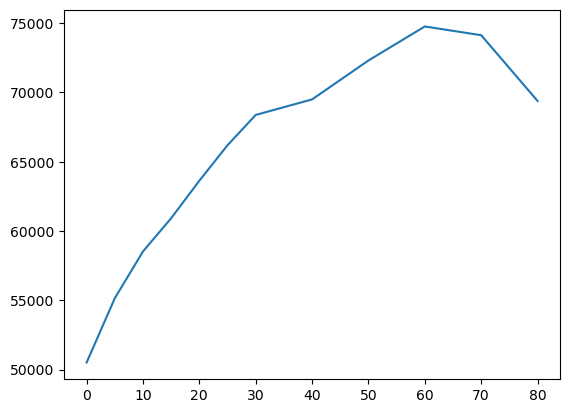

In [ ]:
plt.plot(future_bau_w)
plt.plot()

In [ ]:
total_emissions_left

1209.7794699941937

In [ ]:
(((np.sum(future_gdp/future_pop))**(1/3.) * np.sum(future_bau)) / factor)

0.18938593428458197

In [ ]:
np.nansum(future_bau_w) - total_emissions_left

4358.941335358839

In [ ]:
(((np.sum(future_gdp/future_pop))**(1/3.) * np.sum(future_bau)) / factor)

0.18938593428458197

In [ ]:
ap

-385947.130157156

In [ ]:
future_gdp

array([[6.12473688e+10, 6.26743972e+10, 6.41203059e+10, ...,
        3.01522242e+12, 3.11943452e+12, 3.22364663e+12],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [2.76397845e+10, 2.90926127e+10, 3.03963273e+10, ...,
        3.87381349e+10, 3.84953773e+10, 3.82526198e+10],
       ...,
       [2.44523472e+13, 2.57634549e+13, 2.70119285e+13, ...,
        6.63884290e+13, 6.71079518e+13, 6.78274745e+13],
       [1.61430554e+13, 1.69627250e+13, 1.76871603e+13, ...,
        5.14200617e+13, 5.21562603e+13, 5.28924589e+13],
       [1.03838777e+14, 1.09972344e+14, 1.15359344e+14, ...,
        5.37751871e+14, 5.45732106e+14, 5.53712340e+14]])

In [ ]:
np.sum(future_gdp/future_pop)

2450574.9023496965

In [ ]:
(np.sum(future_gdp/future_pop) / np.sum(future_gdp_w/future_pop_w))**(1/3.)

1.379013402495268

In [ ]:
self.xr_budgets_static.sel(Variable = ["GF", "PC", "AP"], Ccat="C1", Region = "WORLD")

<xarray.Dataset>
Dimensions:   (Variable: 3)
Coordinates:
    Region    <U5 'WORLD'
    Ccat      <U2 'C1'
  * Variable  (Variable) object 'GF' 'PC' 'AP'
Data variables:
    Value     (Variable) float64 1.116e+03 1.116e+03 4.359e+03

In [ ]:
self.xr_total.GHG_f

<xarray.DataArray 'GHG_f' (Category: 12, Time: 111)>
array([[      nan,       nan,       nan, ...,  3.749014,  3.654259,  3.559504],
       [      nan,       nan,       nan, ...,  0.775741,  0.640296,  0.504851],
       [      nan,       nan,       nan, ..., -1.459038, -1.626758, -1.794478],
       ...,
       [      nan,       nan,       nan, ..., 72.01654 , 72.032356, 72.048172],
       [      nan,       nan,       nan, ..., 75.872834, 75.802519, 75.732203],
       [      nan,       nan,       nan, ..., 96.930745, 96.392724, 95.854704]])
Coordinates:
  * Time      (Time) int32 1990 1991 1992 1993 1994 ... 2096 2097 2098 2099 2100
  * Category  (Category) object 'C1' 'C1+C2' 'C2' 'C3' ... 'C7' 'C7+C8' 'C8'

## Checks

In [ ]:
var = "A2_gdp_net"
reg = "WORLD"
cat = "C1+C2"
s = float(self.xr_budgets_static.sel(Region=reg, Ccat=cat, Variable=var).Value)
l = float(self.xr_budgets_linear.sel(Region=reg, Ccat=cat, Variable=var).sum(dim="Time").Value)
d = float(self.xr_budgets_scenario.sel(Region=reg, Ccat=cat, Variable=var).sum(dim="Time").Value)
print('static', s)
print('linear', l)
print('dynamic', d)

static 1207.6500617079716
linear 1207.6500617079714
dynamic 1209.7794699941937


In [ ]:
var = "A1_gdp_pos"
reg = "G20"
cat = "C1"
year = 2050
l = float(self.xr_budgets_linear.sel(Region=reg, Ccat=cat, Variable=var, Time=year).Value)
d = float(self.xr_budgets_scenario.sel(Region=reg, Ccat=cat, Variable=var, Time=year).Value)
print('linear', l)
print('dynamic', d)

linear 11.99143796288674
dynamic 9.63999609965339


In [ ]:
reg = "G20"
cat = "C4"
var = "A1_"
s = float(self.xr_budgets_static.sel(Region=reg, Ccat=cat, Variable="A1_gdp_pos").Value) / float(self.xr_budgets_static.sel(Region="WORLD", Ccat=cat, Variable="A1_gdp_pos").Value)
l = float(self.xr_budgets_linear.sel(Region=reg, Ccat=cat, Variable="A1_gdp_pos").sum(dim="Time").Value) / float(self.xr_budgets_linear.sel(Region="WORLD", Ccat=cat, Variable="A1_gdp_pos").sum(dim="Time").Value)
d = float(self.xr_budgets_scenario.sel(Region=reg, Ccat=cat, Variable="A1_gdp_pos").sum(dim="Time").Value) / float(self.xr_budgets_scenario.sel(Region="WORLD", Ccat=cat, Variable="A1_gdp_pos").sum(dim="Time").Value)
print('static', s)
print('linear', l)
print('dynamic', d)

static 0.4633499366265762
linear 0.46334993662657625
dynamic 0.4633499366265762


In [ ]:
self.xr_budgets_scenario.sel(Region="EU", Time=2030, Variable='GF')

<xarray.Dataset>
Dimensions:   (Ccat: 12)
Coordinates:
  * Ccat      (Ccat) object 'C1' 'C1+C2' 'C2' 'C3' ... 'C6' 'C7' 'C7+C8' 'C8'
    Region    <U2 'EU'
    Time      int64 2030
    Variable  <U2 'GF'
Data variables:
    Value     (Ccat) float64 2.188 2.761 3.205 3.182 ... 3.876 4.289 4.369 4.821

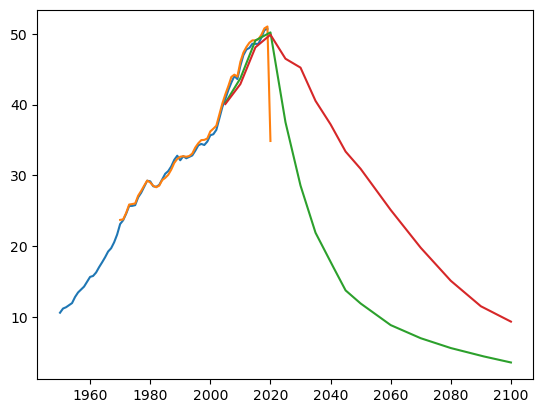

In [ ]:
plt.plot(self.xr_total.Time, self.xr_total.sel(ISO="WORLD").GHG_p)
plt.plot(self.xr_total.Time, self.xr_total.sel(ISO="WORLD").GHG_e)

plt.plot(self.xr_total.Time, self.xr_total.sel(ISO="WORLD", Category="C1").GHG_f)
plt.plot(self.xr_total.Time, self.xr_total.sel(ISO="WORLD", Category="C4").GHG_f)